In [ ]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import anndata as adata

In [ ]:
import torch

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ot
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import TI as spt
from anndata import AnnData

In [ ]:
import StPedf

In [ ]:
random_seed = 2025
StPedf.fix_seed(random_seed)

In [ ]:
exp_df = pd.read_csv("F:/StPedf/data/Simulated_dataset/Simulated_dataset_1/simulated_expression.csv", index_col=0)
exp_df.head()

,cell1,cell2,cell3,cell4,cell5,cell6,cell7,cell8,cell9,cell10,...,cell991,cell992,cell993,cell994,cell995,cell996,cell997,cell998,cell999,cell1000
Burn1_TF1,2,2,8,6,5,2,7,1,3,4,...,4,2,3,6,2,4,2,3,8,4
Burn2_TF1,4,4,9,3,5,3,2,4,3,3,...,7,6,2,6,3,1,4,7,7,6
Burn3_TF1,4,1,6,3,2,3,5,2,4,4,...,8,5,5,2,3,5,4,6,7,2
Burn4_TF1,5,3,5,6,3,1,1,3,3,2,...,1,1,1,4,5,3,4,4,6,3
A1_TF1,2,4,8,4,1,2,4,3,2,2,...,5,1,2,2,3,3,3,4,5,0


In [ ]:
meta_df = pd.read_csv("F:/StPedf/data/Simulated_dataset/Simulated_dataset_1/simulated_input.csv", index_col=0)
meta_df.head()

,Sample,UMAP1,UMAP2,time,lineage,Cell_Type,r,theta,x,y
Cell_ID,,,,,,,,,,
cell562,Simulation,3.141247,6.648345,0.325221,1,A,17.108442,92.387241,-0.712621,17.093594
cell779,Simulation,3.083348,6.590264,0.457619,1,A,20.294256,323.012103,16.210293,-12.209964
cell637,Simulation,3.039063,6.706306,0.459809,1,A,20.342765,184.818052,-20.270883,-1.708626
cell168,Simulation,2.943072,6.653493,0.491919,1,A,21.041083,250.849126,-6.902670,-19.876627
cell393,Simulation,3.054525,6.533715,0.491919,1,A,21.041083,162.404762,-20.056692,6.360523


In [7]:
adata = adata.AnnData(exp_df.T)

In [8]:
adata.obs = adata.obs.join(meta_df)
adata.obs.head()

,Sample,UMAP1,UMAP2,time,lineage,Cell_Type,r,theta,x,y
cell1,Simulation,5.341630,-4.380950,990.257958,2,J,783.098137,127.503785,-476.760985,621.242027
cell2,Simulation,0.004179,0.829091,227.543106,1,D,452.535960,139.165465,-342.389193,295.902748
cell3,Simulation,-7.408302,-3.197001,558.623873,1,F,709.056758,349.044340,696.133880,-134.755730
cell4,Simulation,-7.239113,-3.128485,573.547864,1,F,718.465781,297.288026,329.390581,-638.509924
cell5,Simulation,-5.224359,-1.215822,500.117479,1,F,670.899196,24.532851,610.332666,278.567349


In [ ]:
adata.obsm['spatial'] = adata.obs[['x', 'y']].values
adata.obs['cluster'] = adata.obs['Cell_Type'].astype('category')


AnnData结构概要:
AnnData object with n_obs × n_vars = 1000 × 135
    obs: 'Sample', 'UMAP1', 'UMAP2', 'time', 'lineage', 'Cell_Type', 'r', 'theta', 'x', 'y', 'cluster'
    obsm: 'spatial'

观察注释列: ['Sample', 'UMAP1', 'UMAP2', 'time', 'lineage', 'Cell_Type', 'r', 'theta', 'x', 'y', 'cluster']

空间坐标维度: (1000, 2)


In [ ]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['count'] = adata.X.copy()

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]

sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=50)


In [ ]:
graph_dict = StPedf.graph_construction(
    adata, 
    12,
    mode='AlphaComplex',  
    alpha_n_neighbors=30  
)

空间图构建完成: dict_keys(['adj_norm', 'adj_label', 'norm_value'])


In [ ]:
# gpu
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

sedr_net = StPedf.Sedr(
    adata.obsm['X_pca'], 
    graph_dict, 
    mode='clustering',
    device=device
)



In [ ]:
using_dec = True 
if using_dec:
    sedr_net.train_with_dec(N=500)  
else:
    sedr_net.train_without_dec(N=500)

sedr_feat, _, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

100%|██████████| 200/200 [00:02<00:00, 81.29it/s]


In [ ]:
import torch
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ot
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import TI as spt
from anndata import AnnData

In [ ]:
import collections
collections.Iterable = collections.abc.Iterable  # 临时修复兼容问题
from scipy.sparse import csr_matrix  

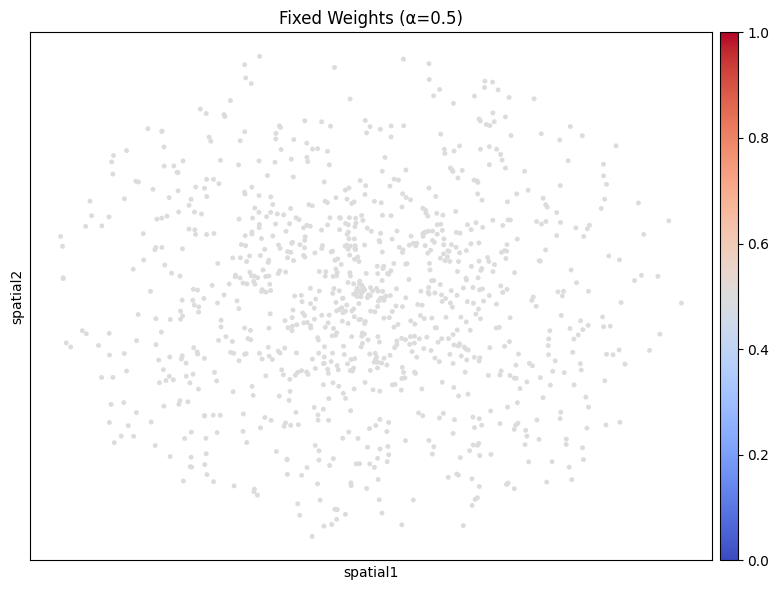

In [ ]:
def construct_fixed_weight_transition_matrix(
    adata: AnnData,
    sedr_key: str = 'SEDR',
    spatial_key: str = 'spatial',
    reg: float = 0.1,
    fixed_alpha: float = 0.5,  
    spot_size: float = 100
):

    sedr_emb = adata.obsm[sedr_key]
    spatial_coords = adata.obsm[spatial_key]

    sedr_dist = pairwise_distances(sedr_emb)
    spatial_dist = pairwise_distances(spatial_coords)

    sedr_dist /= sedr_dist.max()
    spatial_dist /= spatial_dist.max()

    adata.obs['spatial_weight'] = fixed_alpha  

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    sc.pl.embedding(
        adata, 
        basis=spatial_key, 
        color='spatial_weight', 
        ax=ax, 
        show=False, 
        title=f'Fixed Weights (α={fixed_alpha})',
        cmap='coolwarm',
        size=spot_size,
        vmin=0,  
        vmax=1  
    )
    
    plt.tight_layout()
    plt.show()
  
    M = np.zeros_like(spatial_dist)
    for i in range(len(adata)):

        M[i] = fixed_alpha * spatial_dist[i] + (1 - fixed_alpha) * sedr_dist[i]

    a = b = np.ones(M.shape[0]) / M.shape[0]
    Gs = ot.sinkhorn(a, b, M, reg=reg)
    
    return Gs

trans_fixed_weight = construct_fixed_weight_transition_matrix(
    adata,
    sedr_key='SEDR',
    spatial_key='spatial',
    reg=0.0214,
    fixed_alpha=0.5, 
    spot_size=50
)

adata.obsp["fixed_weight_trans"] = trans_fixed_weight



In [ ]:

adata.obsp["trans"] = adata.obsp["fixed_weight_trans"]

print("Transfer matrix 'trans' added with shape:", adata.obsp["trans"].shape)

Transfer matrix 'trans' added with shape: (1000, 1000)


In [ ]:
start_cells = spt.set_start_cells(
    adata,
    select_way='cell_type',
    cell_type='A',
    n_neigh=30,
    basis='spatial'
)


adata.obs["ptime"] = spt.get_ptime(adata, start_cells=start_cells)

起始细胞数量: 102


In [ ]:

adata.obsm['X_spatial'] = adata.obsm['spatial']

In [24]:
adata.uns["E_grid"], adata.uns["V_grid"] = spt.get_velocity(adata, basis="spatial", n_neigh_pos=50)

Cell velocities stored in 'velocity_spatial'


In [ ]:
VecFld = spt.VectorField(
    adata,
    basis='spatial',
    velocity_key='velocity_spatial',  
    n_neighbors=80,
    smooth=1.2 
)

Locator attempting to generate 2124 ticks ([-1080.0, ..., 1043.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2124 ticks ([-1080.0, ..., 1043.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2124 ticks ([-1080.0, ..., 1043.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2124 ticks ([-1080.0, ..., 1043.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2124 ticks ([-1080.0, ..., 1043.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2124 ticks ([-1080.0, ..., 1043.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2115 ticks ([-1033.0, ..., 1081.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2115 ticks ([-1033.0, ..., 1081.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2115 ticks ([-1033.0, ..., 1081.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2115 t

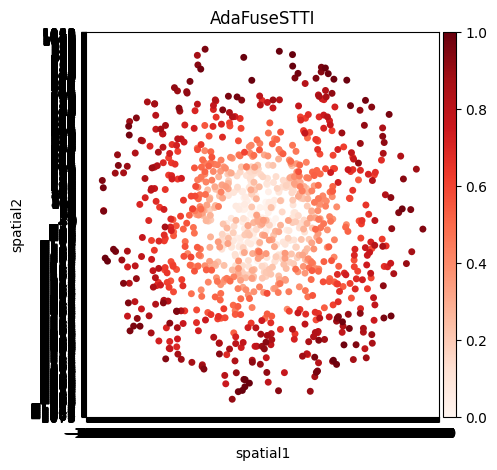

In [ ]:
import matplotlib.ticker as ticker  

fig, axs = plt.subplots(figsize=(5, 5))
sc.pl.embedding(
    adata,
    basis='spatial',       
    color='ptime',          
    show=False,
    ax=axs,
    color_map='Reds',
    title='AdaFuseSTTI',
    size=100
)
axs.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
axs.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

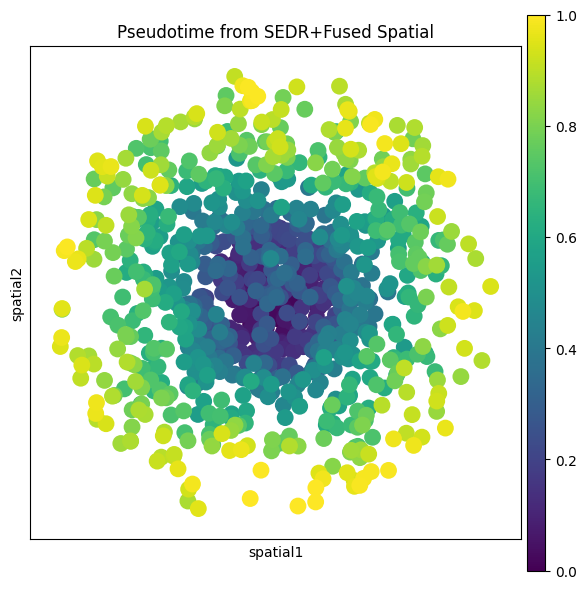

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.spatial(adata, color='ptime', title='Pseudotime from SEDR+Fused Spatial', 
              size=1.5, spot_size=50, ax=ax, show=False)  
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import spearmanr

ptime = adata.obs['ptime'].values
clusters = adata.obs['Cell_Type'].cat.codes 

corr, p_value = spearmanr(ptime, clusters)
print(f"Spearman: {corr:.4f}")

Spearman相关系数（一致性值）: 0.6019


In [ ]:
import numpy as np
from scipy.stats import spearmanr

ptime = adata.obs['ptime'].values
Time = adata.obs['time'].values 

corr, p_value = spearmanr(ptime, Time)
print(f"Spearman: {corr:.4f}")

Spearman相关系数（一致性值）: 0.7798


In [ ]:
from scipy.stats import kendalltau

ptime = adata.obs['ptime'].values
Time = adata.obs['time'].values 

corr, p_value = kendalltau(ptime, Time)
print(f"Kendall: {corr:.4f}")


Kendall相关系数: 0.6316
